# Fig 8: Correlation of IWV 

*Figure 8 caption:*   
WV for a) Radiosonde vs. HATPRO and b) Radiosonde vs. ICON-LEM. For
HATPRO and ICON, the IWV is taken as the 20-minute average (1100 to 1120 UTC). Only days
between August to December 2020 were used. Days where HATPRO was flagged, were excluded
in a) but not in b). The least-squares fit is shown by the red line defined by the given intercepts
and coefficients. The identity line is marked by the blue dotted line.

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import re   # regular expression
import os
from sklearn import linear_model

import RS_class  # This contains our Radiosonde class to extract the IWV for a single RS file

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set_style("whitegrid")

# IWV comparison

Plotting the IWV from the radiosonde data, hatpro and icon. The radiosondes start around 11 UTC and because most humidity is in the lower layers of the troposphere the average is taken for 11-11:20 UTC for ICON and HATPRO. 

## 1. Data
- Get the IWV for each day from the RS (using RS_class)
- Get ICON 11-12 UTC data
- Get Hatpro 11-12 UTC data

### 1.1. Radiosonde data
Here the calculation uses the `RS_class` and there are two different implementations for the saturation water vapor equation. One uses Goff and Gratch (`_gg`) and the other Hyland and Wexler (`_hw`). See more details in the implementation in `RS_class`   
Both computation versions give almost the identical result so it doesn't matter which one is used.

In [7]:
# Radiosonde data
# note to myself: this is horrible programming ... I don't care because this doesn't take long

year = "2020"
months = ["08", "09", "10", "11", "12"]
days = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", 
     "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
     "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]

datadir = "/data/radiosondes/raw/01004_ny-alesund/"

RS_IWV_gg = np.empty((0,3))

for m in months:
    for d in days:
        file_regex = re.compile('NYA-RS_'+year+m+d+'[0-9]*' )
        for root, dirs, files in os.walk(datadir):
            for file in files:
                if file_regex.match(file):
                   # print(file)
                    filepath = datadir+file
                    rs_data=RS_class.RS_data_gg(filepath)
                    RS_IWV_gg = np.append(RS_IWV_gg, [[rs_data.get_IWV_gg(), int(m),int(d)]], axis=0)


### 1.2 ICON data

In [8]:
# ICON IWV
lem_file = "data/model/11UTC_icon_lem_meteograms/nyalesund_icon_lem_202008-12_11UTC.nc"
lem_ds = xr.open_dataset(lem_file)

lem_rs_IWV = np.empty((0,2))

# Select days where there was a radiosonde:
for c in range(len(RS_IWV_gg)):
    m = RS_IWV_gg[c,1]
    d = RS_IWV_gg[c,2]
    
    # All possible date formats have to be gone through because int version didn't work for pandas
    if (d < 10) & (m < 10):
        tstart = year+"0"+str(int(m))+"0"+str(int(d))+" 11:00"
        tend = year+"0"+str(int(m))+"0"+str(int(d))+" 11:20"
    elif (d < 10) & (m >= 10):
        tstart = year+str(int(m))+"0"+str(int(d))+" 11:00"
        tend = year+str(int(m))+"0"+str(int(d))+" 11:20"
    elif (d >= 10) & (m < 10):
        tstart = year+"0"+str(int(m))+str(int(d))+" 11:00"
        tend = year+"0"+str(int(m))+str(int(d))+" 11:20"
    else:
        tstart = year+str(int(m))+str(int(d))+" 11:00"
        tend = year+str(int(m))+str(int(d))+" 11:20"
    
    lem_subset = lem_ds.TQV.where((lem_ds.time >= pd.to_datetime(tstart, format='%Y%m%d %H:%M')) &
                 (lem_ds.time <= pd.to_datetime(tend, format='%Y%m%d %H:%M')), drop=True)

    if (lem_subset.size > 0) & (~np.isnan(float(RS_IWV_gg[c,0]))):
        lem_rs_IWV = np.append(lem_rs_IWV, [[float(RS_IWV_gg[c,0]), lem_subset.mean().values]], axis=0)
        #print(tstart, tend)

### 1.3 HATPRO data

In [9]:
hatprofile = "data/hatpro/nyalesund_hatpro_202008-12_11UTC.nc"
hatpro_11UTC = xr.open_dataset(hatprofile)

In [11]:
# remove flagged data
hatpro_11UTC_noflagged = hatpro_11UTC.where( (np.isnan(hatpro_11UTC.flag_tbx)) & 
                                            (np.isnan(hatpro_11UTC.flag)), drop=True)

hatpro_rs_IWV = np.empty((0,2))

for c in range(len(RS_IWV_gg)):
    m = RS_IWV_gg[c,1]
    d = RS_IWV_gg[c,2]

    # All possible date formats have to be gone through because int version didn't work for pandas
    if (d < 10) & (m < 10):
        tstart = year+"0"+str(int(m))+"0"+str(int(d))+" 11:00"
        tend = year+"0"+str(int(m))+"0"+str(int(d))+" 11:20"
    elif (d < 10) & (m >= 10):
        tstart = year+str(int(m))+"0"+str(int(d))+" 11:00"
        tend = year+str(int(m))+"0"+str(int(d))+" 11:20"
    elif (d >= 10) & (m < 10):
        tstart = year+"0"+str(int(m))+str(int(d))+" 11:00"
        tend = year+"0"+str(int(m))+str(int(d))+" 11:20"
    else:
        tstart = year+str(int(m))+str(int(d))+" 11:00"
        tend = year+str(int(m))+str(int(d))+" 11:20"
    
    hatpro_subset = hatpro_11UTC_noflagged.prw.where((hatpro_11UTC_noflagged.time >= pd.to_datetime(tstart)) &
                 (hatpro_11UTC_noflagged.time <= pd.to_datetime(tend)), drop=True)

    if (hatpro_subset.values[~np.isnan(hatpro_subset.values)].size > 0) & (~np.isnan(float(RS_IWV_gg[c,0]))):
        
        hatpro_rs_IWV = np.append(hatpro_rs_IWV,
                                  [[float(RS_IWV_gg[c,0]), 
                                    hatpro_subset.values[~np.isnan(hatpro_subset.values)].mean()]],
                                  axis=0)

## 2. Plots and Stats

In [14]:
# Statistical values for ICON-LEM

diff = lem_rs_IWV[:,1]-lem_rs_IWV[:,0]
N = len(lem_rs_IWV[:,0])

RMSE = np.sqrt(sum(diff**2) / N)

# corrected standard deviation
stddev = np.sqrt(sum((diff-np.mean(diff))**2) / (N-1))
#np.std(diff, dtype=np.float64)

bias = sum(diff) / N

# mean absolute error:
MAE = sum(abs(diff)) / N
stddev

1.029200343797012

In [15]:
# Statistical values for hatpro

diff = hatpro_rs_IWV[:,1]-hatpro_rs_IWV[:,0]
N = len(hatpro_rs_IWV[:,0])

RMSE = np.sqrt(sum(diff**2) / N)

# corrected standard deviation
stddev = np.sqrt(sum((diff-np.mean(diff))**2) / (N-1))
#np.std(diff, dtype=np.float64)

bias = sum(diff) / N

# mean absolute error:
MAE = sum(abs(diff)) / N
print(stddev, RMSE, bias)

0.5028300189947569 0.6440541044721956 -0.4050397905941734


In [22]:
# ICON-LEM Linear regression to determine slope using least squares method
reg = linear_model.LinearRegression()
reg.fit(lem_rs_IWV[:,0].reshape(len(lem_rs_IWV[:,0]),1), lem_rs_IWV[:,1])

rs_test_icon = np.linspace(0,30,60).reshape(len(np.linspace(0,30,60)),1)
lem_pred = reg.predict(rs_test_icon)

In [24]:
# HATPRO Linear regression to determine slope using least squares method 
reg = linear_model.LinearRegression()
reg.fit(hatpro_rs_IWV[:,0].reshape(len(hatpro_rs_IWV[:,0]),1), hatpro_rs_IWV[:,1])

rs_test_hatpro = np.linspace(0,30,60).reshape(len(np.linspace(0,30,60)),1)
hatpro_pred = reg.predict(rs_test_hatpro)

### 2.2. Plot

<IPython.core.display.Javascript object>


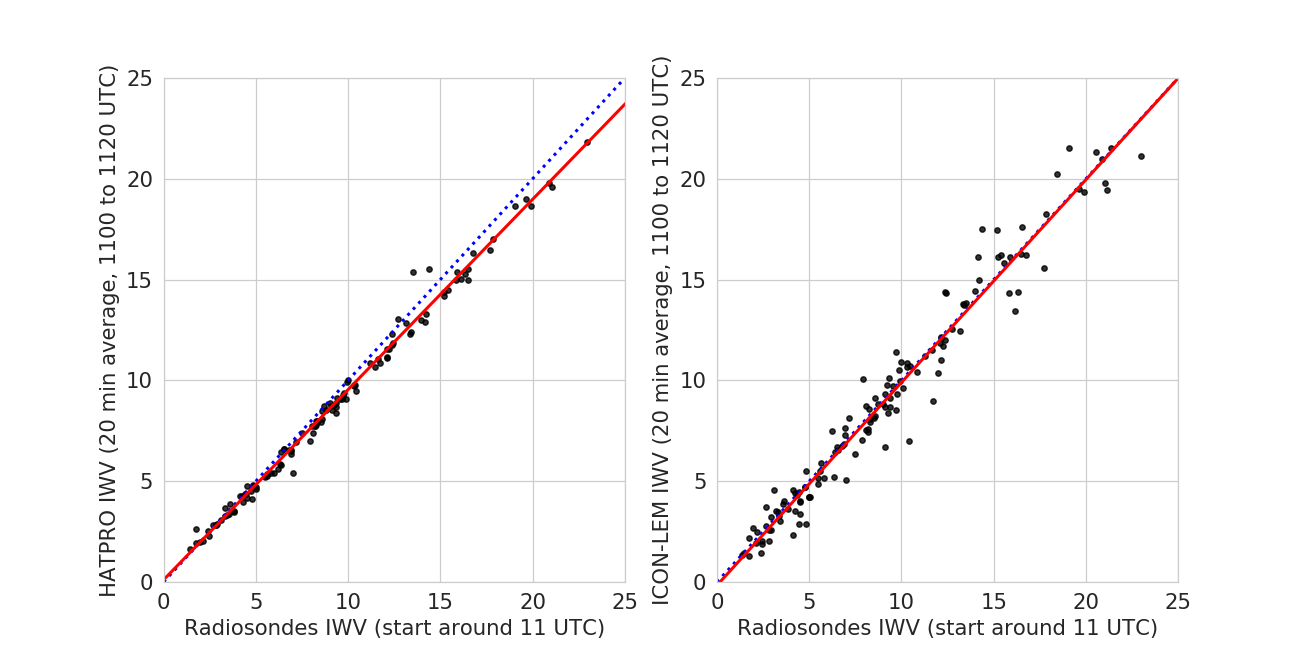

In [29]:
x = [0,30]
y = [0,30]

fig = plt.figure(figsize=(12,6))
plt.rcParams["font.size"] = "14"

ax1 = fig.add_subplot(121)
ax1.scatter(hatpro_rs_IWV[:,0], hatpro_rs_IWV[:,1], color="black", alpha=0.8, s=12)
plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel("Radiosondes IWV (start around 11 UTC)")
plt.ylabel("HATPRO IWV (20 min average, 1100 to 1120 UTC)")

ax1.plot(x,y, color="blue", linestyle="dotted", linewidth=2)
ax1.plot(rs_test_hatpro, hatpro_pred, color="red", linestyle="solid",  linewidth=2)

#plt.suptitle(leastsqr_text )
#plt.title("RMSE = 0.6441, bias = -0.4050, stdev of error = 0.5028 ")

ax2 = fig.add_subplot(122)
ax2.scatter(lem_rs_IWV[:,0], lem_rs_IWV[:,1], color="black", alpha=0.8, s=12)
plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel("Radiosondes IWV (start around 11 UTC)")
plt.ylabel("ICON-LEM IWV (20 min average, 1100 to 1120 UTC)")

ax2.plot(x,y, linestyle="dotted", color="blue", linewidth=2)
ax2.plot(rs_test_icon, lem_pred, color="red", linestyle="solid", linewidth=2)

#plt.title("RMSE = 1.031, bias = -0.106, stdev of error = 1.0292  ")
#plt.suptitle(leastsqr_text )

#plt.savefig("fig_8_hatpro_rs_icon_IWV_fit.png", dpi=300, format="png")